# Aprendizagem Automática 2022/2023
## Course Project

### Grupo 12
- Ana Araújo - 59457
- Francisco Frazão - 57484
- Pedro Almeida - 58844

   For this project, we were given three datasets related to the country's population, fertility rate, and life expectancy from 1960 up to 2016. The main objective is to produce a model that predicts the variables above described, ie. country population, fertility rate, and life expectancy. These variables should be predicted for the year 2017. We must do a comparison with the actual historical data from the World Bank Site.\
   With this data we are going to select the best model, using a few parameter tuning. Also, this work is to be done for only 10 countries, randomly selected. For the predictions, the data that is going to be used corresponds to the last three years known. Based on the data present in the last three years (2014, 2015, and 2016), the year 2017 will be predicted. However as the expectation of the variance is low, we should not use the last three years directly but rather the delta between these three years. This last point is part of the data processing step.\
   Finally, some conclusions will be taken regarding the results obtained from the models.

#### Content Table

#### [1. Data Preprocessing](#section1)
- 1.1 Population
- 1.2 Fertility
- 1.3 Life Expectancy

#### [2. Hyperparameter Search](#section2)
- 2.1 Decision tree

#### [3. Model Evaluation](#section3)
- 3.1 Population
- 3.2 Fertility
- 3.3 Life Expectancy

#### [4. Predictions](#section4)
- 4.1 Population
- 4.2 Fertility
- 4.3 Life Expectancy

#### [5. Discussion and Conclusions](section#5)

**Import libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split, cross_validate, ParameterGrid
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, max_error,accuracy_score
from scipy.stats import pearsonr
from sklearn.tree import DecisionTreeRegressor

import warnings
import random
warnings.filterwarnings("ignore")

In [113]:
def printRegStatistics(truth, preds):
    print("The RVE is: ", explained_variance_score(truth, preds))
    print("The rmse is: ", mean_squared_error(truth, preds, squared=False))
    corr, pval = pearsonr(truth, preds)
    print("The Correlation Score is is: %6.4f (p-value=%e)"%(corr,pval))
    print("The Maximum Error is is: ", max_error(truth, preds))
    print("The Mean Absolute Error is: ", mean_absolute_error(truth, preds))
    
def calculate_rate_of_change(data):
  # Convert the data to a numpy array
    data = np.array(data)
  # Initialize an empty list to store the rates of change
    rates_of_change = []
  # Loop through the columns
    for i in range(1, data.shape[1]):
        rate_of_change = data[:, i] - data[:, i-1]
        rates_of_change.append(rate_of_change)
    return np.array(rates_of_change).T   
    
def division(x):
    #splits each line of the given df in a way that each line of the new df will be composed
    #of df[i][j] followed by increments in j till j+4
    new_list = []
    for i in range(len(x)):
        for j in range(0,len(x.iloc[i])):
            if j+4 >= len(x.iloc[i]):
                break
            else:
                new_list.append([x.iloc[i][j],x.iloc[i][j+1],x.iloc[i][j+2],x.iloc[i][j+3],x.iloc[i][j+4]])
    new_list = np.array(new_list)
    return new_list   

def index_country(x):
    #multiplica o indice por 53 porque cada país vai ter 53 vezes 4 colunas 
    index = []
    for i in x.index:
        for j in range(53):
            index.append(i)
    return index

def sampler(df,df_wb, samples):
    #selects randomly 10 contries and returns the data for the last 3 years
    ## MUST BE USED RIGTH AFTER THE DF.DROP
    X_test=[]
    for country in samples:
        df1 = df.loc[df['Country Name']==country]
        df1 = df1.values
        a = [df1[0,-4],df1[0,-3],df1[0,-2],df1[0,-1]]
        if None not in a:
            X_test.append(a)
        else:
            b = [df1[0,-5],df1[0,-4],df1[0,-3],df1[0,-2]]
            if None not in b:
                X_test.append(b)
            else:
                c = [df1[0,-6],df1[0,-5],df1[0,-4],df1[0,-3]]
                if None not in b:
                    X_test.append(c)
                else:
                    a = [df1[0,-7],df1[0,-6],df1[0,-5],df1[0,-4]]
                    X_test.append(a)
    y_test=[]
    real_pop =[]
    for country in samples:
        a = df_wb.loc[df_wb['Country Name']==country,'2016'].values
        b = df_wb.loc[df_wb['Country Name']==country,'2017'].values
        y_test.append([float(a),float(b)])  
        real_pop.append(float(b))
    return calculate_rate_of_change(X_test),calculate_rate_of_change(y_test), real_pop

def naif_model_testing(X_train, X_test, y_train, y_test, max_depth, min_samples_leaf, data_2016):
    #test 3 approaches and print out the results
    
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    preds_lr=lr.predict(X_test)
    data=  [float(i+j) for i,j in zip(data_2016, preds_lr)]
    
    dtr = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    dtr.fit(X_train,y_train)
    preds_dtr=dtr.predict(X_test)
    
    regr = Ridge(alpha=10, max_iter=9999999).fit(X_train, y_train)
    preds_regr=regr.predict(X_test)
    print(" - Linear Regression:")
    printRegStatistics(y_test, preds_lr)
    print()
    print(" - Decision Tree Regression:")
    printRegStatistics(y_test, preds_dtr)
    print()
    print(" - Ridge Regression:")
    printRegStatistics(y_test, preds_regr)
    
    return data, preds_dtr, preds_regr

def metric_evaluation(X_train, X_test, y_train, y_test):
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    table = []
    #build multiple linear regression model
    for i in range(2,20):
        for j in range(2,10):
            model = DecisionTreeRegressor(max_depth=i, min_samples_leaf=j)
    #use k-fold CV to evaluate model
            scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error',cv=cv, n_jobs=-1)
            preds = cross_val_predict(model, X_test,y_test, cv=cv, n_jobs=-1)
    #obtain metrics
            rmse = mean_squared_error(y_test, preds, squared=False)
            mae = mean_absolute_error(y_test, preds)
            rve = explained_variance_score(y_test, preds)
            corr, pval=pearsonr(y_test, preds)
            table.append([i,j,rmse,mae,rve,corr,pval])        
    return pd.DataFrame(table, columns=['max depth', 'min sampl leaf', 'rmse','mae','rve','corr','pval']) 

**Creation of necessary functions:**\
We create the necessary functions for printing the metrics evaluation for each model, calculateion the rate of change, the additional line for the fourth year for each country, mutliplication of the index, for randomly choose 10 countries, train the models and for models validation.\
\
To deal with the missing values, we have made some steps. We have chosen a course of action based on more than just the examination of the deltas. The deltas are always calculated by subtracting T from T-1 and T-2 from T, respectively. In essence, we divided it into groups of four years, with the first three years serving as a predictor for the fourth. As a result, the first line represents the first year and the three years that follow, the second line represents the second year that follows the three years, and so on. Each country will have 53 columns using this method. Another action we have done is to randomly choose 10 countries for analysis, after which we will get data pertaining to the previous four.

<a id='section1'></a>
## 1. Data Preprocessing
We dropped some useless columns, such as “Country Code”, “Indicator
Name” and “Indicator Code”. An important remark is to highlight that algorithms with linear regressions don't accept missing values to train, thus we also dropped rows in the transformed dataset with missing values.
### 1.1 Population

In [3]:
df = pd.read_csv('country_population.csv')
wb_pop = pd.read_csv('wb_pop.csv')


df.drop(['Country Code','Indicator Name','Indicator Code'],axis=1,inplace=True)

samples = random.sample(list(df['Country Name'].values), 10)

X_test_pop,y_test_pop, pop_2017= sampler(df,wb_pop,samples)


pop_2016 = []
for country in samples:
    a = df.loc[df['Country Name']==country,'2016'].values
    pop_2016.append(int(a))

df = df.set_index('Country Name')

y_test_pop = [float(i) for i in y_test_pop]

In [5]:
# Creates pandas DataFrame.  
dg = pd.DataFrame(calculate_rate_of_change(division(df)), index = index_country(df), columns=['D0','D1','D2','D3']) 

#A ideia é usar D0,D1 e D2 para prever D3
dg = dg.dropna()
dg.head()

,D0,D1,D2,D3
Aruba,1227.0,787.0,470.0,337.0
Aruba,787.0,470.0,337.0,328.0
Aruba,470.0,337.0,328.0,355.0
Aruba,337.0,328.0,355.0,340.0
Aruba,328.0,355.0,340.0,331.0


### 1.2 Fertility

In [39]:
df2 = pd.read_csv('fertility_rate.csv')
wb_fert = pd.read_csv('wb_fert.csv')


df2.drop(['Country Code','Indicator Name','Indicator Code'],axis=1,inplace=True)


X_test_fert,y_test_fert,fert_2017= sampler(df2,wb_fert,samples2)

fert_2016 = []
for country in samples2:
    a = df2.loc[df2['Country Name']==country,'2016'].values
    fert_2016.append(float(a))

df2 = df2.set_index('Country Name')
y_test_fert = [float(i) for i in y_test_fert]

In [40]:
# Creates pandas DataFrame.  
dg2 = pd.DataFrame(calculate_rate_of_change(division(df2)), index = index_country(df2), columns=['D0','D1','D2','D3']) 

#A ideia é usar D0,D1 e D2 para prever D3
dg2 = dg2.dropna()
dg2.head()

,D0,D1,D2,D3
Aruba,-0.165,-0.184,-0.200,-0.212
Aruba,-0.184,-0.200,-0.212,-0.217
Aruba,-0.200,-0.212,-0.217,-0.217
Aruba,-0.212,-0.217,-0.217,-0.208
Aruba,-0.217,-0.217,-0.208,-0.191


### 1.3 Life Expectancy

In [41]:
df3 = pd.read_csv('life_expectancy.csv')
wb_le = pd.read_csv('wb_le.csv')


df3.drop(['Country Code','Indicator Name','Indicator Code'],axis=1,inplace=True)

X_test_le,y_test_le,le_2017= sampler(df3,wb_le,samples)

le_2016 = []
for country in samples:
    a = df3.loc[df3['Country Name']==country,'2016'].values
    le_2016.append(float(a))

df3 = df3.set_index('Country Name')
y_test_le = [float(i) for i in y_test_le]

In [42]:
# Creates pandas DataFrame.  
dg3 = pd.DataFrame(calculate_rate_of_change(division(df3)), index = index_country(df3), columns=['D0','D1','D2','D3']) 

#A ideia é usar D0,D1 e D2 para prever D3
dg3 = dg3.dropna()
dg3.head()

,D0,D1,D2,D3
Aruba,0.412,0.370,0.343,0.326
Aruba,0.370,0.343,0.326,0.322
Aruba,0.343,0.326,0.322,0.327
Aruba,0.326,0.322,0.327,0.333
Aruba,0.322,0.327,0.333,0.341


In [43]:
X_pop = dg.drop(columns=['D3'])
y_pop = dg['D3']

In [44]:
X_fert = dg2.drop(columns=['D3'])
y_fert = dg2['D3']

In [45]:
X_le = dg3.drop(columns=['D3'])
y_le = dg3['D3']

All the data obtained from the transformations explained above were used as a
training set since the predictions would be for 2017 and the information regarding this year was not included in the training set.\
In order to do the predictions, the deltas of the last four years of each
variable/country have been used. Lastly, to test the results against reality, we have resorted to the dataset from the World Bank to the year 2017.

<a id='section2'></a>
## 2. Hyperparameters Search
We did a hyperparameter search for Decision Tree Regression.
### 2.1 Decision Tree
#### 2.1.1 Population

In [77]:
X_train_pop, X_test_pop2, y_train_pop, y_test_pop2 = train_test_split(X_pop, y_pop, test_size=0.25, random_state=123)

In [78]:
df_h_pop = metric_evaluation(X_train_pop, X_test_pop2, y_train_pop, y_test_pop2)
df_h_pop.sort_values(by=['rmse'], ascending=True).head()

,max depth,min sampl leaf,rmse,mae,rve,corr,pval
40,7,2,448602.227899,129352.838065,0.998219,0.999112,0.0
104,15,2,467732.717858,115906.162835,0.998064,0.999034,0.0
32,6,2,469884.698898,148542.055677,0.998046,0.999023,0.0
96,14,2,470394.065299,118170.932321,0.998041,0.999023,0.0
73,11,3,471288.957974,118143.829529,0.998035,0.999023,0.0


#### 2.1.2 Fertility

In [79]:
X_train_fert, X_test_fert2, y_train_fert2, y_test_fert2 = train_test_split(X_fert, y_fert, test_size=0.25, random_state=123)

In [80]:
df_h_fert = metric_evaluation(X_train_fert, X_test_fert2, y_train_fert2, y_test_fert2)
df_h_fert.sort_values(by=['rmse'], ascending=True).head()

,max depth,min sampl leaf,rmse,mae,rve,corr,pval
27,5,5,0.042025,0.021594,0.653627,0.809381,0.0
31,5,9,0.042105,0.021429,0.652326,0.808302,0.0
28,5,6,0.042238,0.021509,0.650114,0.807205,0.0
30,5,8,0.042290,0.021499,0.649248,0.806465,0.0
39,6,9,0.042698,0.021429,0.642441,0.803407,0.0


#### 2.1.3 Life Expectancy

In [81]:
X_train_le, X_test_le2, y_train_le, y_test_le2 = train_test_split(X_le, y_le, test_size=0.25, random_state=123)

In [82]:
df_h_le = metric_evaluation(X_train_le, X_test_le2, y_train_le, y_test_le2)
df_h_le.sort_values(by=['rmse'], ascending=True).head()

,max depth,min sampl leaf,rmse,mae,rve,corr,pval
47,7,9,0.213764,0.096740,0.605188,0.780424,0.0
52,8,6,0.214336,0.095416,0.603085,0.781604,0.0
55,8,9,0.214431,0.095192,0.602722,0.779490,0.0
44,7,6,0.214451,0.096639,0.602664,0.780470,0.0
60,9,6,0.214476,0.094420,0.602556,0.781755,0.0


<a id='section3'></a>
## 3. Model Evaluation
Over this part, three regression models have been chosen: Linear Regression,
Decision Trees, and Ridge Regression. These models have been fitted with the data coming from the three variables under analysis: population, fertility, and life expectancy.\
\
The data to test are not integrated into the train data, therefore the split was not done. Otherwise we could be exposed to the risk of overfitting.
### 3.1 Population

In [95]:
prediction_lr, prediction_dtr, prediction_rr = naif_model_testing(X_pop, X_test_pop, y_pop, y_test_pop, 7, 2, pop_2016)

 - Linear Regression:
The RVE is:  0.9993246362865138
The rmse is:  276235.3226545486
The Correlation Score is is: 0.9997 (p-value=0.000000e+00)
The Maximum Error is is:  3781791.8378947377
The Mean Absolute Error is:  77510.50302793038

 - Decision Tree Regression:
The RVE is:  0.999531451504452
The rmse is:  230066.2146520809
The Correlation Score is is: 0.9998 (p-value=0.000000e+00)
The Maximum Error is is:  2731588.703703705
The Mean Absolute Error is:  85775.80120172768

 - Ridge Regression:
The RVE is:  0.9993246362865138
The rmse is:  276235.3226545369
The Correlation Score is is: 0.9997 (p-value=0.000000e+00)
The Maximum Error is is:  3781791.8378959
The Mean Absolute Error is:  77510.50302792876


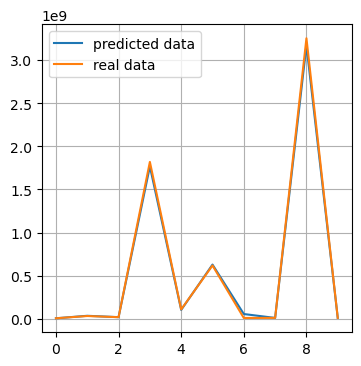

In [121]:
plt.figure(figsize=(4,4))
plt.plot(range(len(prediction_lr)),prediction_lr, label = 'predicted data' )
plt.plot(range(len(pop_2017)),pop_2017, label='real data')
plt.grid()
plt.legend()
plt.show()

Regarding the population, the results obtained are very good with all models. This applies to Linear Regression, Decision Trees, and Ridge Regression. For Linear Regression we have an RVE of more than 0,999. For Decision Trees the values are not much different, always with results above 0,999, and for Ridge
Regression, the same scenario, with values above 0,999. All the values give signs of very good predictions, and when we put in comparison the real data, facing the predicted counterparts, we barely can distinguish both lines. Still, we did some research on choosing the best hyperparameters for the values given by Decision Trees.\
Also, the correlation scores for the three models were very close to 1. This can be effectively seen when comparing the real data with the predicted one. 

### 3.2 Fertility

In [102]:
prediction2_lr, prediction2_dtr, prediction2_rr = naif_model_testing(X_fert, X_test_fert, y_fert, y_test_fert, 5, 5, fert_2016)

 - Linear Regression:
The RVE is:  -0.3518422702371442
The rmse is:  0.04155885388369767
The Correlation Score is is: 0.1841 (p-value=6.107247e-01)
The Maximum Error is is:  0.10421779533788686
The Mean Absolute Error is:  0.030910960020573176

 - Decision Tree Regression:
The RVE is:  -0.7210727920934648
The rmse is:  0.04806914671702207
The Correlation Score is is: 0.1203 (p-value=7.405818e-01)
The Maximum Error is is:  0.1118318581743539
The Mean Absolute Error is:  0.03466930118594254

 - Ridge Regression:
The RVE is:  -0.29248481985602437
The rmse is:  0.040461662541377126
The Correlation Score is is: 0.1868 (p-value=6.052672e-01)
The Maximum Error is is:  0.10204221499790775
The Mean Absolute Error is:  0.030139931929677267


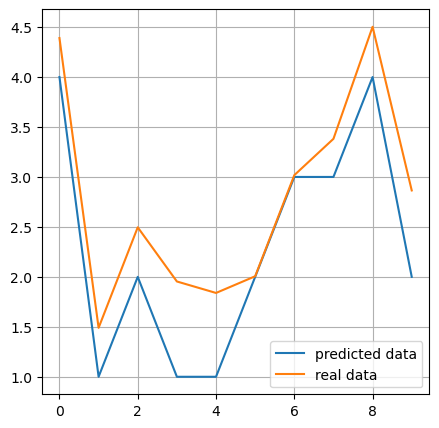

In [117]:
plt.figure(figsize=(4,4))
plt.plot(range(len(prediction2_lr)),prediction2_lr, label = 'predicted data' )
plt.plot(range(len(fert_2017)),fert_2017, label='real data')
plt.grid()
plt.legend()
plt.show()

As for the fertility variable, the results were not so promising. Both models have struggled to give good predictions. The scores, namely the RVE are low.
Even so, this is not an impediment to our models not capturing the signals of the correlations. How it can be seen in plot 2, despite the predictions not being accurate, the signals were captured by the models. Our metric score,
RVE, for this specific variable has been negative for all the models. We have obtained an RVE value for Linear Regression of - 0,352, for Decision Tree Regression of -0,721, and for Ridge Regression of -0,292. This means there
exists a negative correlation between these variables. Nevertheless, as it is possible to observe both by the plot 2 and the predictions below, the values predicted are not that much outliers. The highest correlation score obtained has been for Linear Regression and it is a value of 0,184.

### 3.3 Life Expectancy

In [104]:
prediction3_lr, predicyion3_dtr, prediction3_rr = naif_model_testing(X_le, X_test_le, y_le, y_test_le, 7, 9, le_2016)

 - Linear Regression:
The RVE is:  0.6910653492678249
The rmse is:  0.11091239237105113
The Correlation Score is is: 0.8394 (p-value=2.384600e-03)
The Maximum Error is is:  0.18732877217452598
The Mean Absolute Error is:  0.09130533928241824

 - Decision Tree Regression:
The RVE is:  -0.09467729088268273
The rmse is:  0.18687099882366298
The Correlation Score is is: 0.2415 (p-value=5.014621e-01)
The Maximum Error is is:  0.3224978270694364
The Mean Absolute Error is:  0.15607697494217335

 - Ridge Regression:
The RVE is:  0.695850632435854
The rmse is:  0.10969219196134755
The Correlation Score is is: 0.8415 (p-value=2.271794e-03)
The Maximum Error is is:  0.18418815089149604
The Mean Absolute Error is:  0.09056090457179275


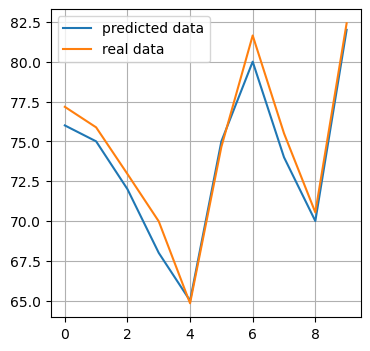

In [122]:
plt.figure(figsize=(4,4))
plt.plot(range(len(prediction3_lr)),prediction3_lr, label = 'predicted data' )
plt.plot(range(len(le_2017)),le_2017, label='real data')
plt.grid()
plt.legend()
plt.show()

This variable, along with fertility, was not so well predicted either. However in this case the values for the metrics we have evaluated have performed better. For Linear Regression we have obtained an RVE value of 0,691, for Decision Tree Regression, -0,095, and for Ridge Regression a very similar value when compared to the one obtained through Decision Tree, 0,696. Moreover, when we observe both the plot and the predictions below it is possible to figure out that this Life Expectancy variable has been predicted in a very close way against the real data.

<a id='section4'></a>
## 4. Predictions
### 4.1 Population

In [114]:
for country,pred, real in zip(samples, prediction_lr, pop_2017):
    print(f"\n {country}: Predicted population in 2017 would be {pred} but the real population is {real}")


 Slovak Republic: Predicted population in 2017 would be 5435852 but the real population is 5439232.0

 Peru: Predicted population in 2017 would be 34193606 but the real population is 31605486.0

 Kazakhstan: Predicted population in 2017 would be 18495775 but the real population is 18037776.0

 South Asia (IDA & IBRD): Predicted population in 2017 would be 1766399632 but the real population is 1818868706.0

 Ethiopia: Predicted population in 2017 would be 102561595 but the real population is 108197950.0

 Latin America & the Caribbean (IDA & IBRD countries): Predicted population in 2017 would be 628005575 but the real population is 617875842.0

 Austria: Predicted population in 2017 would be 54706646 but the real population is 8797566.0

 Jordan: Predicted population in 2017 would be 9513980 but the real population is 10215381.0

 Early-demographic dividend: Predicted population in 2017 would be 3170676849 but the real population is 3252529883.0

 Sweden: Predicted population in 2017 w

### 4.2 Fertility

In [115]:
for country,pred, real in zip(samples, prediction2_lr, fert_2017):
    print(f"\n {country}: Predicted fertility in 2017 would be {pred} but the real fertility is {real}")


 Slovak Republic: Predicted fertility in 2017 would be 4 but the real fertility is 4.39

 Peru: Predicted fertility in 2017 would be 1 but the real fertility is 1.49

 Kazakhstan: Predicted fertility in 2017 would be 2 but the real fertility is 2.496

 South Asia (IDA & IBRD): Predicted fertility in 2017 would be 1 but the real fertility is 1.95382639771591

 Ethiopia: Predicted fertility in 2017 would be 1 but the real fertility is 1.839

 Latin America & the Caribbean (IDA & IBRD countries): Predicted fertility in 2017 would be 2 but the real fertility is 2.006

 Austria: Predicted fertility in 2017 would be 3 but the real fertility is 3.01792967354235

 Jordan: Predicted fertility in 2017 would be 3 but the real fertility is 3.38160941952177

 Early-demographic dividend: Predicted fertility in 2017 would be 4 but the real fertility is 4.503

 Sweden: Predicted fertility in 2017 would be 2 but the real fertility is 2.865


### 4.3 Life Expectancy

In [109]:
for country,pred, real in zip(samples, prediction3_lr, le_2017):
    print(f"\n {country}: Predicted life expectancy in 2017 would be {pred} but the real life expectancy is {real}")


 Slovak Republic: Predicted life expectancy in 2017 would be 76 but the real life expectancy is 77.1658536585366

 Peru: Predicted life expectancy in 2017 would be 75 but the real life expectancy is 75.879

 Kazakhstan: Predicted life expectancy in 2017 would be 72 but the real life expectancy is 72.95

 South Asia (IDA & IBRD): Predicted life expectancy in 2017 would be 68 but the real life expectancy is 69.9791020756437

 Ethiopia: Predicted life expectancy in 2017 would be 65 but the real life expectancy is 64.838

 Latin America & the Caribbean (IDA & IBRD countries): Predicted life expectancy in 2017 would be 75 but the real life expectancy is 74.6563800397882

 Austria: Predicted life expectancy in 2017 would be 80 but the real life expectancy is 81.6439024390244

 Jordan: Predicted life expectancy in 2017 would be 74 but the real life expectancy is 75.502

 Early-demographic dividend: Predicted life expectancy in 2017 would be 70 but the real life expectancy is 70.5420565547556

<a id='section5'></a>
## 5. Discussion and Conclusions
\
The fact that the X_Test and Y_Test data include missing values is undoubtedly one of the project's potential enhancements. Although we are aware that some algorithms cannot accept missing numbers, because our data is chosen at random, occasionally the algorithms identify missing values and report an error. An implementation in the code where each time the entire process discovers a missing value it will hop to the next one until it finds no missing values would be a potential remedy to this problem.\
We have deliberately chosen not to include the Ridge Regression hyperparameter search since the first time we tried it, the results were the same, so we continue with the default settings.\
It is clear from the projections themselves that the variable population produced superior outcomes. We may have gotten better results for the other two variables if we had tried various methods and tested different models. It is crucial to emphasize that the random countries chosen have a significant impact on these outcomes. Because even while we can get better results using the same models for certain countries, the situation is different for others with more erratic data.